In [1]:
# Standard Python imports
from datetime import datetime
from dateutil.tz import tzlocal
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 30)
%matplotlib inline

In [2]:
# Standard PyNWB imports
from pynwb.icephys import CurrentClampStimulusSeries, VoltageClampSeries
from pynwb import NWBHDF5IO

In [3]:
# Imports needed from the ndx-icephys-meta
from ndx_icephys_meta.icephys import ICEphysFile
from ndx_icephys_meta.test.test_icephys import ICEphysMetaTestBase

# 1. Create a test icephys NWB file with our new metadata tables

In [4]:
test_filename = 'test_icephys_file.h5'
nwbfile = ICEphysMetaTestBase.create_icephs_meta_testfile(
     filename=test_filename,    # write the file to disk for testing
     add_custom_columns=True,   # Add a custom column to each icephys metadata table for testing
     randomize_data=True        # Randomize the data in the simulus and response for some more realistic behavior
    )

# 2. Visualize the basic data organization

## 2.1. Show the hierarchical organization of the icephys data

**Note** The relevant TimeSeries for stimulus and response are linked to directly from the table so that we can access them easily in conjunction with the other metadata, so that all data becomes easily accesible via a single table.

In [5]:
icmeta_hier = nwbfile.icephys_experimental_conditions.to_hierarchical_dataframe()
print(nwbfile.icephys_experimental_conditions.name)
display(icmeta_hier)

experimental_conditions


source_table                                                                                                                                                                                                                                             intracellular_recordings  \
label                                                                                                                                                                                                                                                                          id   
(experimental_conditions, id) (experimental_conditions, t... (repetitions, id) (repetitions, type) (sequential_recordings, id) (sequential_recordings, sti... (sequential_recordings, type) (simultaneous_recordings, id) (simultaneous_recordings, tag)                            
100000                        32.0                           10000             R1                  1000                        StimType_1                     T1                            100                           0                                                     0   
                                                                                                                                                                                                                          0                                                     1   
                                                                                                                                                                                            101                           1                                                     2   
                                                                                                                                                                                                                          1                                                     3   
                                                             10001             R2                  1001                        StimType_2                     T2                            102                           2                                                     4   
                                                                                                                                                                                                                          2                                                     5   
                                                                                                                                                                                                                          2                                                     6   
                                                                                                   1002                        StimType_3                     T3                            103                           3                                                     7   
                                                                                                                                                                                                                          3                                                     8   
                                                                                                                                                                                                                          3                                                     9   
100001                        24.0                           10002             R1                  1003                        StimType_1                     T1                            104                           4                                                    10   
                                                                                                                          

## 2.2. Show the hierarchical organization of the data objects in the NWB HDF5 file

Using the nwb_docutils we can visulalize the organization of the data in the HDF5 file as well.  

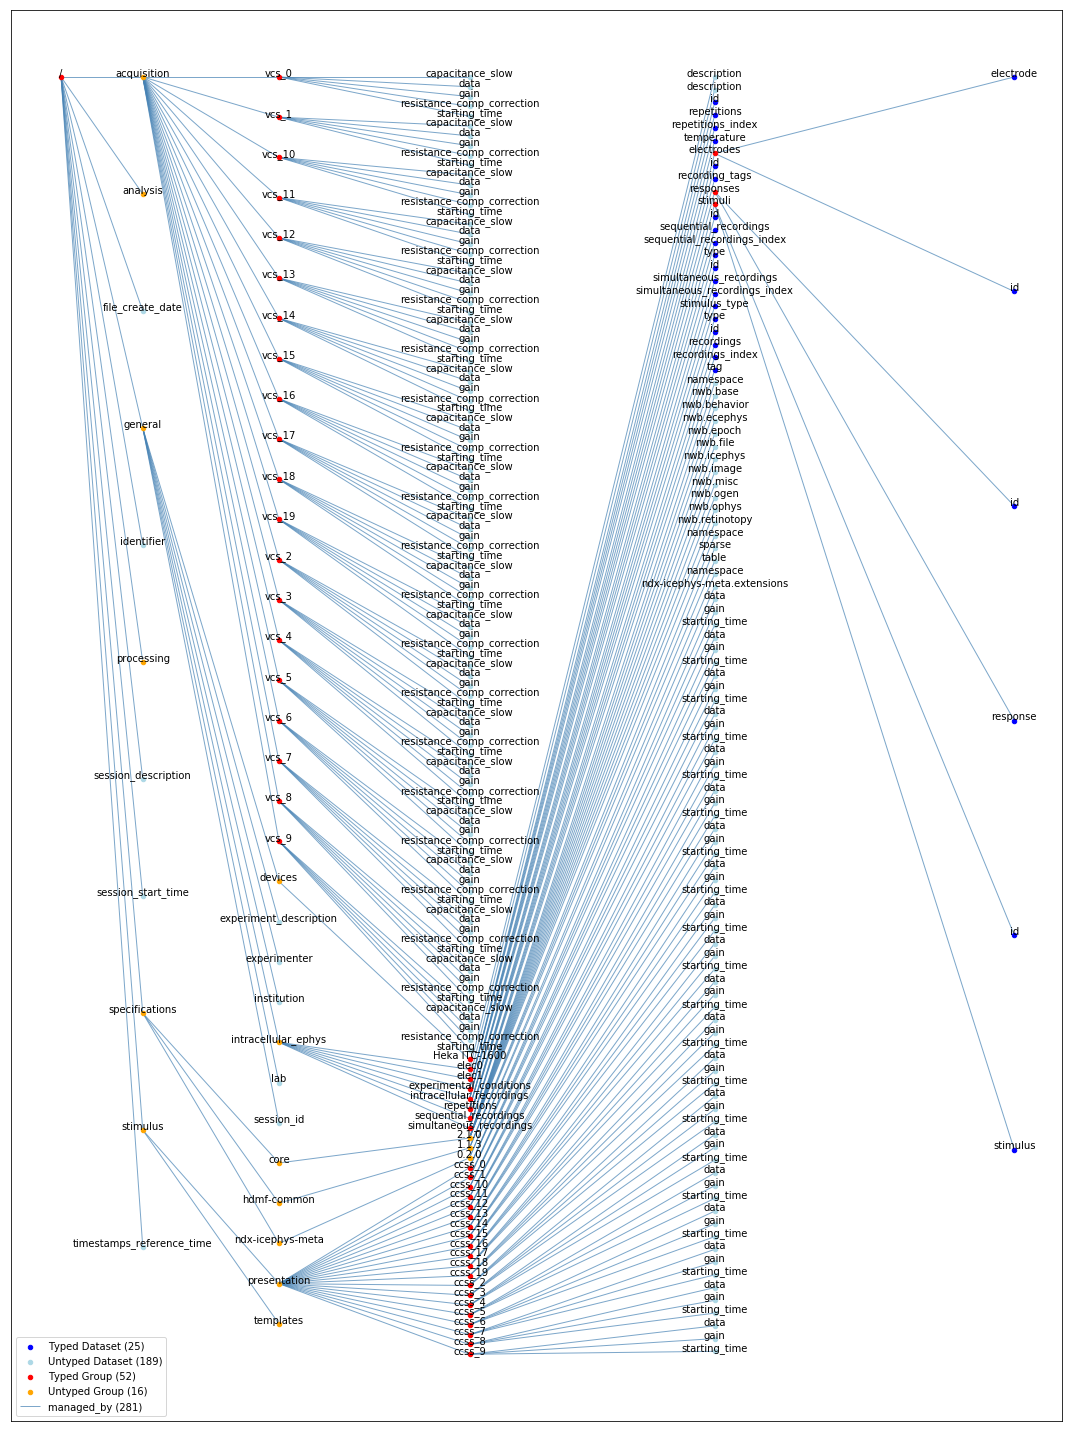

In [6]:
from nwb_docutils.doctools import render as docrender
h5hier = docrender.HierarchyDescription.from_hdf5(test_filename)
nxgraph = docrender.NXGraphHierarchyDescription(data=h5hier,
                                                include_attributes=False, # don't show attributes to clean up the plot
                                                include_groups=True,
                                                include_datasets=True,
                                                include_links=False
                                               )
fig = nxgraph.draw(figsize=(15,20),
                   label_offset=(0.0, 0.003),
                   label_font_size=10,

                   axis_on=True)

# 3. Do Common Queries

Here some common queries we identified

* Given a response, return the stimulus
* Given a stimulus, return the response
* Given a stimulus, return the stimulus type
* Given an electrode, return all sweeps recorded with it
* Given a stimulus type, return all derived stimuli 
* Get the list of all stimulus types 
* Given a stimulus type, get all the repetitions in which it is present [Enrico]
* Given a stimulus type and a repetition, get all the responses [Enrico]
* Given a stimulus or response, return all other stimuli and responses recorded during the same sweep* 
* Given a sweep, return its repetition
* Given a repetition, return all sweeps within that repetition
* Given a sweep or repetition, return its condition
* Given a condition, return all sweeps or repetitions
* Given a sweep, return all other sweeps of the same repetition
* Given a stimulus and a condition, return all sweeps across repetitions and average the responses

For query we can either: **(1)** interact with the DyanmicTables from PyNWB directly or using individual Pandas data tables (i.e, using the data in its normalized form, with data distrubted across the Conditions, Runs, SweepSequences, Sweeps, and IntracellularRecordings tables)  or we can **(2)** load all metadata (i.e., the DynamicTables but not the TimeSeries) and create a single denormalized dataframe that we can then use to implement the queries. In the following we first show to prepare data in Pandas DataFrames need for (2) and then afterwards we'll show how we can perform the various queries. 

# 3.1 Data Preparations

In Section 2.1 above we already showed how we can load the data into a hierarchical DataFrame. In this section we load all data into a single denormalized Pandas DataFrame to simplify query and show how we can expand compound data columns (i.e,. columns storing tuples in Pandas). 

In [7]:
icmeta = nwbfile.icephys_experimental_conditions.to_denormalized_dataframe()
print(nwbfile.icephys_experimental_conditions.name + " denormalized")
display(icmeta)

experimental_conditions denormalized


source_table experimental_conditions             repetitions       \
label                             id temperature          id type   
0                             100000        32.0       10000   R1   
1                             100000        32.0       10000   R1   
2                             100000        32.0       10000   R1   
3                             100000        32.0       10000   R1   
4                             100000        32.0       10001   R2   
5                             100000        32.0       10001   R2   
6                             100000        32.0       10001   R2   
7                             100000        32.0       10001   R2   
8                             100000        32.0       10001   R2   
9                             100000        32.0       10001   R2   
10                            100001        24.0       10002   R1   
11                            100001        24.0       10002   R1   
12                            100001        24.0       10002   R1   
13                            100001        24.0       10002   R1   
14                            100001        24.0       10003   R2   
15                            100001        24.0       10003   R2   
16                            100001        24.0       10003   R2   
17                            100001        24.0       10003   R2   
18                            100001        24.0       10003   R2   
19                            100001        24.0       10003   R2   

source_table sequential_recordings                    simultaneous_recordings  \
label                           id stimulus_type type                      id   
0                             1000    StimType_1   T1                     100   
1                             1000    StimType_1   T1                     100   
2                             1000    StimType_1   T1                     101   
3                             1000    StimType_1   T1                     101   
4                             1001    StimType_2   T2                     102   
5                             1001    StimType_2   T2                     102   
6                             1001    StimType_2   T2                     102   
7                             1002    StimType_3   T3                     103   
8                             1002    StimType_3   T3                     103   
9                             1002    StimType_3   T3                     103   
10                            1003    StimType_1   T1                     104   
11                            1003    StimType_1   T1                     104   
12                            1003    StimType_1   T1                     105   
13                            1003    StimType_1   T1                     105   
14                            1004    StimType_2   T2                     106   
15                            1004    StimType_2   T2                     106   
16                            1004    StimType_2   T2                     106   
17                            1005    StimType_3   T3                     107   
18                            1005    StimType_3   T3                     107   
19                            1005    StimType_3   T3                     107   

source_table     intracellular_recordings                electrodes  \
label        tag                       id recording_tags         id   
0              0                        0             A1          0   
1              0                        1             A2          1   
2              1                        2             B1          2   
3              1                        3             B2          3   
4              2                        4             C1          4   
5              2                        5             C2          5   
6              2                        6             C3          6   
7              3                        7             D1   

Next we show how we can expand the tuples in the stimulus and response column to be separate columns instead.

In [8]:
stimulus_df = pd.DataFrame(icmeta.stimuli.stimulus.tolist(), 
                           columns=['start', 'count', 'stimulus']) 
response_df = pd.DataFrame(icmeta.responses.response.tolist(), 
                           columns=['start', 'count', 'response']) 
display(stimulus_df) # as an example we show the stimulus here, but the response looks very similar

,start,count,stimulus
0,0,10,ccss_0 pynwb.icephys.Volta...
1,0,10,ccss_1 pynwb.icephys.Volta...
2,0,10,ccss_2 pynwb.icephys.Volta...
3,0,10,ccss_3 pynwb.icephys.Volta...
4,0,10,ccss_4 pynwb.icephys.Volta...
5,0,10,ccss_5 pynwb.icephys.Volta...
6,0,10,ccss_6 pynwb.icephys.Volta...
7,0,10,ccss_7 pynwb.icephys.Volta...
8,0,10,ccss_8 pynwb.icephys.Volta...
9,0,10,ccss_9 pynwb.icephys.Volta...


Using the same approach we can also easily add details from the individual stimulus (and response) objects to our table by inspecting the objects, e.g., via

In [9]:
stimulus_df['name'] = [s.name for s in stimulus_df.stimulus]  # Add a column with the name of the stimulus object
stimulus_df['neurodata_type'] = [s.neurodata_type for s in stimulus_df.stimulus]  # Add a column with the name of the stimulus object
# We can do the same for any fields stored in our stimulus. Here we use a few of them
for field in ['gain', 'rate', 'starting_time']:
    stimulus_df[field] = [getattr(s, field) for s in stimulus_df.stimulus]  # Add a column with the gain from the stimulus 
display(stimulus_df)

,start,count,stimulus,name,neurodata_type,gain,rate,starting_time
0,0,10,ccss_0 pynwb.icephys.Volta...,ccss_0,VoltageClampStimulusSeries,0.059039,10000.0,76.339526
1,0,10,ccss_1 pynwb.icephys.Volta...,ccss_1,VoltageClampStimulusSeries,0.868982,3000.0,85.269901
2,0,10,ccss_2 pynwb.icephys.Volta...,ccss_2,VoltageClampStimulusSeries,0.130114,8000.0,86.969062
3,0,10,ccss_3 pynwb.icephys.Volta...,ccss_3,VoltageClampStimulusSeries,0.311375,4000.0,75.407896
4,0,10,ccss_4 pynwb.icephys.Volta...,ccss_4,VoltageClampStimulusSeries,0.073905,5000.0,88.211451
5,0,10,ccss_5 pynwb.icephys.Volta...,ccss_5,VoltageClampStimulusSeries,0.700935,2000.0,4.785202
6,0,10,ccss_6 pynwb.icephys.Volta...,ccss_6,VoltageClampStimulusSeries,0.668229,8000.0,40.619472
7,0,10,ccss_7 pynwb.icephys.Volta...,ccss_7,VoltageClampStimulusSeries,0.275238,2000.0,39.234877
8,0,10,ccss_8 pynwb.icephys.Volta...,ccss_8,VoltageClampStimulusSeries,0.774061,5000.0,49.769271
9,0,10,ccss_9 pynwb.icephys.Volta...,ccss_9,VoltageClampStimulusSeries,0.287957,4000.0,54.870718


We can naturally also go one step further and directly update our main data table directly to expand the stimulus and reponse columns and add further details from the stimulus and response directly to the table:

In [10]:
def add_stimulus_and_response_details(df, 
                                      expand_stimulus=True, 
                                      expand_response=True, 
                                      add_stimulus_name_and_type=True,
                                      add_stimulus_fields=None,
                                      add_response_name_and_type=True,
                                      add_response_fields=None
                                     ):
    if add_stimulus_fields is None:
        add_stimulus_fields = ['gain', 'rate', 'starting_time']
    if add_response_fields is None:
        add_response_fields = ['gain', 'rate', 'starting_time']
    stimulus_df = pd.DataFrame(df.stimuli.stimulus.tolist(), 
                               columns=['stimulus_start', 'stimulus_count', 'stimulus']) 
    response_df = pd.DataFrame(df.responses.response.tolist(), 
                               columns=['response_start', 'response_count', 'response']) 
    # Expand the stimulus column
    if expand_stimulus:
        for i in stimulus_df.columns:
            df.loc[:,('intracellular_recordings', i)] = stimulus_df.loc[:, i]
    # Expand the response column
    if expand_response:
        for i in response_df.columns:
            df.loc[:,('intracellular_recordings', i)] = response_df.loc[:, i]
    # Add details from the stimulus
    if add_stimulus_name_and_type:
        df.loc[:,('intracellular_recordings', 'stimulus_name')] = [s.name for s in stimulus_df.stimulus]
        df.loc[:,('intracellular_recordings', 'stimulus_neurodata_type')] = [s.neurodata_type for s in stimulus_df.stimulus]
    if len(add_stimulus_fields) > 0:
        for field in add_stimulus_fields:
            df.loc[:,('intracellular_recordings', 'stimulus_' + field )] = [getattr(s, field, None) for s in stimulus_df.stimulus]  
    # Add details from the response
    if add_response_name_and_type:
        df.loc[:,('intracellular_recordings', 'response_name')] = [r.name for r in response_df.response]
        df.loc[:,('intracellular_recordings', 'response_neurodata_type')] = [r.neurodata_type for r in response_df.response]
    if len(add_response_fields) > 0:
        for field in add_response_fields:
            df.loc[:,('intracellular_recordings', 'response_' + field )] = [getattr(r, field, None) for r in response_df.response]  
    
    
    # Add details from the reponse
    return df
    
# Expand the dataframe and display. Here we do this on a copy of the DataFrame as we'll use the regular DataFrame below for our example queries
display(add_stimulus_and_response_details(icmeta.copy()))

source_table experimental_conditions             repetitions       \
label                             id temperature          id type   
0                             100000        32.0       10000   R1   
1                             100000        32.0       10000   R1   
2                             100000        32.0       10000   R1   
3                             100000        32.0       10000   R1   
4                             100000        32.0       10001   R2   
5                             100000        32.0       10001   R2   
6                             100000        32.0       10001   R2   
7                             100000        32.0       10001   R2   
8                             100000        32.0       10001   R2   
9                             100000        32.0       10001   R2   
10                            100001        24.0       10002   R1   
11                            100001        24.0       10002   R1   
12                            100001        24.0       10002   R1   
13                            100001        24.0       10002   R1   
14                            100001        24.0       10003   R2   
15                            100001        24.0       10003   R2   
16                            100001        24.0       10003   R2   
17                            100001        24.0       10003   R2   
18                            100001        24.0       10003   R2   
19                            100001        24.0       10003   R2   

source_table sequential_recordings                    simultaneous_recordings  \
label                           id stimulus_type type                      id   
0                             1000    StimType_1   T1                     100   
1                             1000    StimType_1   T1                     100   
2                             1000    StimType_1   T1                     101   
3                             1000    StimType_1   T1                     101   
4                             1001    StimType_2   T2                     102   
5                             1001    StimType_2   T2                     102   
6                             1001    StimType_2   T2                     102   
7                             1002    StimType_3   T3                     103   
8                             1002    StimType_3   T3                     103   
9                             1002    StimType_3   T3                     103   
10                            1003    StimType_1   T1                     104   
11                            1003    StimType_1   T1                     104   
12                            1003    StimType_1   T1                     105   
13                            1003    StimType_1   T1                     105   
14                            1004    StimType_2   T2                     106   
15                            1004    StimType_2   T2                     106   
16                            1004    StimType_2   T2                     106   
17                            1005    StimType_3   T3                     107   
18                            1005    StimType_3   T3                     107   
19                            1005    StimType_3   T3                     107   

source_table     intracellular_recordings  ...                \
label        tag                       id  ... stimulus_name   
0              0                        0  ...        ccss_0   
1              0                        1  ...        ccss_1   
2              1                        2  ...        ccss_2   
3              1                        3  ...        ccss_3   
4              2                        4  ...        ccss_4   
5              2                        5  ...        ccss_5   
6              2                        6  ...        ccss_6   
7              3                        7  ...        ccss_7   
8              3                        8  ...        ccss

## Query 1: Given a stimulus type, return all derived stimuli

**Example 1:** Using the custom stimulus type column 

In [11]:
icmeta[ icmeta.sequential_recordings.stimulus_type == 'StimType_1' ]

source_table experimental_conditions             repetitions       \
label                             id temperature          id type   
0                             100000        32.0       10000   R1   
1                             100000        32.0       10000   R1   
2                             100000        32.0       10000   R1   
3                             100000        32.0       10000   R1   
10                            100001        24.0       10002   R1   
11                            100001        24.0       10002   R1   
12                            100001        24.0       10002   R1   
13                            100001        24.0       10002   R1   

source_table sequential_recordings                    simultaneous_recordings  \
label                           id stimulus_type type                      id   
0                             1000    StimType_1   T1                     100   
1                             1000    StimType_1   T1                     100   
2                             1000    StimType_1   T1                     101   
3                             1000    StimType_1   T1                     101   
10                            1003    StimType_1   T1                     104   
11                            1003    StimType_1   T1                     104   
12                            1003    StimType_1   T1                     105   
13                            1003    StimType_1   T1                     105   

source_table     intracellular_recordings                electrodes  \
label        tag                       id recording_tags         id   
0              0                        0             A1          0   
1              0                        1             A2          1   
2              1                        2             B1          2   
3              1                        3             B2          3   
10             4                       10             A1         10   
11             4                       11             A2         11   
12             5                       12             B1         12   
13             5                       13             B2         13   

source_table                                stimuli  \
label                             electrode      id   
0             elec0 pynwb.icephys.Intrac...       0   
1             elec1 pynwb.icephys.Intrac...       1   
2             elec0 pynwb.icephys.Intrac...       2   
3             elec1 pynwb.icephys.Intrac...       3   
10            elec0 pynwb.icephys.Intrac...      10   
11            elec1 pynwb.icephys.Intrac...      11   
12            elec0 pynwb.icephys.Intrac...      12   
13            elec1 pynwb.icephys.Intrac...      13   

source_table                                responses  \
label                              stimulus        id   
0             (0, 10, ccss_0 pynwb.iceph...         0   
1             (0, 10, ccss_1 pynwb.iceph...         1   
2             (0, 10, ccss_2 pynwb.iceph...         2   
3             (0, 10, ccss_3 pynwb.iceph...         3   
10            (0, 10, ccss_10 pynwb.icep...        10   
11            (0, 10, ccss_11 pynwb.icep...        11   
12            (0, 10, ccss_12 pynwb.icep...        12   
13            (0, 10, ccss_13 pynwb.icep...        13   

source_table                                 
label                              response  
0             (0, 10, vcs_0 pynwb.icephy...  
1             (0, 10, vcs_1 pynwb.icephy...  
2             (0, 10, vcs_2 pynwb.icephy...  
3             (0, 10, vcs_3 pynwb.icephy...  
10            (0, 10, vcs_10 pynwb.iceph...  
11            (0, 10, vcs_11 pynwb.iceph...  
12            (0, 10, vcs_12 pynwb.iceph...  
13            (0, 10, vcs_13 pynwb.iceph...

**Example 2:** Based on the neurodata_type of the stimulus.

In [12]:
stimulus_df['neurodata_type'] == 'VoltageClampStimulusSeries'

0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
15    True
16    True
17    True
18    True
19    True
Name: neurodata_type, dtype: bool

## Query 2: Get the list of all stimulus types 

In [13]:
unique_stimulus_types = np.unique(icmeta.sequential_recordings.stimulus_type)
print(unique_stimulus_types)

['StimType_1' 'StimType_2' 'StimType_3']
